# Introduction

This project will focus on exploring the capabilities of Bayesian optimization, specifically employing BayBE, in the discovery of novel corrosion inhibitors for materials design. Initially, we will work with a randomly chosen subset from a comprehensive database of electrochemical responses of small organic molecules. Our goal is to assess how Bayesian optimization can speed up the screening process across the design space to identify promising compounds. We will compare different strategies for incorporating alloy information, while optimizing the experimental parameters with respect to the inhibitive performance of the screened compounds.

# Initizalization

Loading libraries and data files:

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from baybe import Campaign
from baybe.objective import Objective
from baybe.parameters import NumericalDiscreteParameter, SubstanceParameter, CategoricalParameter
from baybe.recommenders import RandomRecommender, TwoPhaseMetaRecommender
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget

df_AA2024 = pd.read_excel('data/averaged_filtered_AA2024.xlsx')
df_AA5000 = pd.read_excel('data/averaged_filtered_AA5000.xlsx')
df_AA7075 = pd.read_excel('data/averaged_filtered_AA7075.xlsx')
df_AA1000 = pd.read_excel('data/averaged_filtered_AA1000.xlsx')
df_Al = pd.read_excel('data/averaged_filtered_Al.xlsx')

# change this for campaigns on different datasets
df_active = df_AA2024

if df_active is df_AA2024:
    exp_dataset_name = 'AA2024'
elif df_active is df_AA5000:
    exp_dataset_name = 'AA5000'
elif df_active is df_AA7075:
    exp_dataset_name = 'AA7075'
elif df_active is df_AA1000:
    exp_dataset_name = 'AA1000'
elif df_active is df_Al:
    exp_dataset_name = 'Al'

df_active

,SMILES,Time_h,pH,Inhib_Concentrat_M,Salt_Concentrat_M,Efficiency
0,C(=O)(C(=O)[O-])[O-],24.0,4.0,0.0010,0.10,20.00
1,C(=O)(C(=O)[O-])[O-],24.0,7.0,0.0005,0.05,12.35
2,C(=O)(C(=O)[O-])[O-],24.0,10.0,0.0010,0.10,20.00
3,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,24.0,4.0,0.0010,0.10,30.00
4,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,24.0,7.0,0.0005,0.05,-23.95
...,...,...,...,...,...,...
510,c1ccc2c(c1)[nH]nn2,24.0,7.0,0.0005,0.05,97.95
511,c1ccc2c(c1)[nH]nn2,24.0,10.0,0.0010,0.10,90.00
512,c1ccc2c(c1)[nH]nn2,672.0,7.0,0.0010,0.10,98.00
513,c1ncn[nH]1,24.0,4.0,0.0010,0.10,30.00


In [28]:
lookup = df_active

In [29]:
# chemical space dictionary
unique_SMILES = df_active.SMILES.unique()

def list_to_dict(input_list):
    return {item: item for item in input_list}

smiles_dict =list_to_dict(unique_SMILES)

In [30]:
# parameters

# mordred
parameters_mordred = [
NumericalDiscreteParameter(
    name="Time_h",
    values=df_active['Time_h'].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_active['pH'].unique(),
    # tolerance = 0.004
    ),  
NumericalDiscreteParameter( # Set this as continuous, the values seem quite small?
    name="Inhib_Concentrat_M",
    values= df_active['Inhib_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_active['Salt_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
SubstanceParameter(
    name="SMILES",
    data=smiles_dict,
    encoding="MORDRED",  # optional
    decorrelate=0.7,  # optional
    )        
    ]

# morgan fingerprints
parameters_morgan_fp = [
NumericalDiscreteParameter(
    name="Time_h",
    values=df_active['Time_h'].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_active['pH'].unique(),
    # tolerance = 0.004
    ),  
NumericalDiscreteParameter( # Set this as continuous, the values seem quite small?
    name="Inhib_Concentrat_M",
    values= df_active['Inhib_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_active['Salt_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
SubstanceParameter(
    name="SMILES",
    data=smiles_dict,
    encoding="MORGAN_FP",  # optional
    decorrelate=0.7,  # optional
    )        
    ]

# rdkit
parameters_rdkit = [
NumericalDiscreteParameter(
    name="Time_h",
    values=df_active['Time_h'].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_active['pH'].unique(),
    # tolerance = 0.004
    ),  
NumericalDiscreteParameter( # Set this as continuous, the values seem quite small?
    name="Inhib_Concentrat_M",
    values= df_active['Inhib_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_active['Salt_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
SubstanceParameter(
    name="SMILES",
    data=smiles_dict,
    encoding="RDKIT",  # optional
    decorrelate=0.7,  # optional
    )        
    ]
# one-hot encoding
parameters_ohe = [
NumericalDiscreteParameter(
    name="Time_h",
    values=df_active['Time_h'].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_active['pH'].unique(),
    # tolerance = 0.004
    ),  
NumericalDiscreteParameter( # Set this as continuous, the values seem quite small?
    name="Inhib_Concentrat_M",
    values= df_active['Inhib_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_active['Salt_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
CategoricalParameter(
    name="SMILES",
    values=unique_SMILES,
    encoding="OHE",
    )
]


In [31]:
df_no_target = lookup.drop('Efficiency', axis=1)

# searchspace = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters)
# print('Print test 1')
# objective = Objective(
#     mode="SINGLE", targets=[NumericalTarget(name="Efficiency", mode="MAX")]
# )


searchspace_mordred = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_mordred)

searchspace_morgan = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_morgan_fp)

searchspace_rdkit = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_rdkit)

searchspace_ohe = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_rdkit)


objective = Objective(
    mode="SINGLE", targets=[NumericalTarget(name="Efficiency", mode="MAX")]
)


In [32]:
searchspace_rdkit

SearchSpace(discrete=SubspaceDiscrete(parameters=[NumericalDiscreteParameter(name='Time_h', encoding=None, _values=[0.5, 1.0, 2.0, 3.0, 6.0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0, 192.0, 240.0, 288.0, 336.0, 360.0, 384.0, 432.0, 480.0, 528.0, 576.0, 600.0, 624.0, 672.0], tolerance=0.0), NumericalDiscreteParameter(name='pH', encoding=None, _values=[0.0, 3.3, 4.0, 4.4, 5.4, 5.5, 5.6, 7.0, 10.0], tolerance=0.0), NumericalDiscreteParameter(name='Inhib_Concentrat_M', encoding=None, _values=[1e-05, 5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0012, 0.0018, 0.0024, 0.003, 0.005, 0.01, 0.011, 0.021, 0.022, 0.031, 0.033, 0.042, 0.044, 0.05, 0.1], tolerance=0.0), NumericalDiscreteParameter(name='Salt_Concentrat_M', encoding=None, _values=[0.0, 0.01, 0.05, 0.1, 0.5, 0.6], tolerance=0.0), SubstanceParameter(name='SMILES', data={'C(=O)(C(=O)[O-])[O-]': 'C(=O)(C(=O)[O-])[O-]', 'C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O': 'C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O', 'C(C(C(C(

In [34]:
campaign_mordred = Campaign(searchspace=searchspace_mordred, objective=objective)
campaign_morgan = Campaign(searchspace=searchspace_morgan, objective=objective)
campaign_rdkit = Campaign(searchspace=searchspace_rdkit, objective=objective)
campaign_ohe = Campaign(searchspace=searchspace_ohe, objective=objective)

campaign_rand_mordred = Campaign(
    searchspace=searchspace_mordred,
    recommender=TwoPhaseMetaRecommender(recommender=RandomRecommender()),
    objective=objective,
)
campaign_rand_morgan = Campaign(
    searchspace=searchspace_morgan,
    recommender=TwoPhaseMetaRecommender(recommender=RandomRecommender()),
    objective=objective,
)
campaign_rand_rdkit = Campaign(
    searchspace=searchspace_rdkit,
    recommender=TwoPhaseMetaRecommender(recommender=RandomRecommender()),
    objective=objective,
)

In [35]:
scenarios = {"Mordred": campaign_mordred, #"Random": campaign_rand_mordred,
             "Morgan": campaign_morgan, #"Morgan Random": campaign_rand_morgan,
             "RDKIT": campaign_rdkit,
             "OHE": campaign_ohe, 
             "Random": campaign_rand_rdkit
             }

In [36]:
N_MC_ITERATIONS = 10
N_DOE_ITERATIONS = 50
BATCH_SIZE = 1

results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
    impute_mode="best",
)

  0%|          | 0/50 [00:00<?, ?it/s]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/vscode/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
  2%|2         | 1/50 [00:19<16:09, 19.79s/it]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (inp

In [37]:
results.to_excel(f"./results/{exp_dataset_name}_simulation_{N_MC_ITERATIONS}MC_{N_DOE_ITERATIONS}exp_{BATCH_SIZE}batch.xlsx")

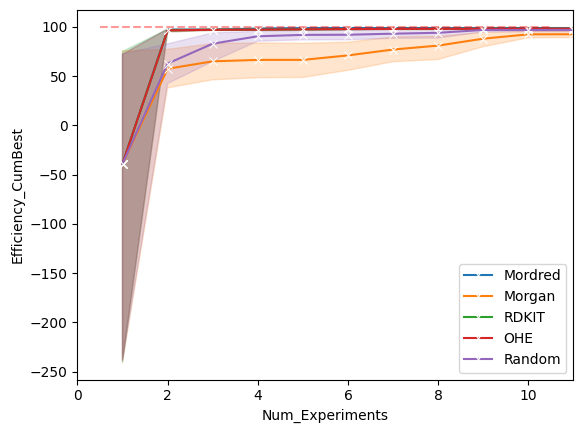

In [38]:
max_yield = lookup["Efficiency"].max()
# plot_results = results[results['Scenario'].isin(['Mordred', 'Morgan', 'RDKIT'])]

# until 10
limit = 10
sns.lineplot(
    data=results, x="Num_Experiments", y="Efficiency_CumBest", hue="Scenario", marker="x"
)
plt.plot([0.5, limit+0.5], [max_yield, max_yield], "--r", alpha=0.4)
plt.legend(loc="lower right")
import matplotlib.pyplot as plt

plt.xlim(0, limit+1)
plt.savefig(f"./img/{exp_dataset_name}_simulation_{N_MC_ITERATIONS}MC_{N_DOE_ITERATIONS}exp_{BATCH_SIZE}batch_first10.png")

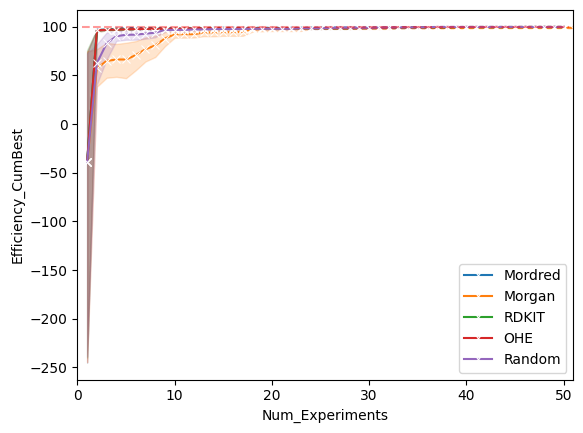

In [39]:
# until 25
limit = 25

sns.lineplot(
    data=results, x="Num_Experiments", y="Efficiency_CumBest", hue="Scenario", marker="x"
)
plt.plot([0.5, N_DOE_ITERATIONS+0.5], [max_yield, max_yield], "--r", alpha=0.4)
plt.legend(loc="lower right")
import matplotlib.pyplot as plt

plt.xlim(0, N_DOE_ITERATIONS+1)
plt.savefig(f"./img/{exp_dataset_name}_simulation_{N_MC_ITERATIONS}MC_{N_DOE_ITERATIONS}exp_{BATCH_SIZE}batch_first25.png")

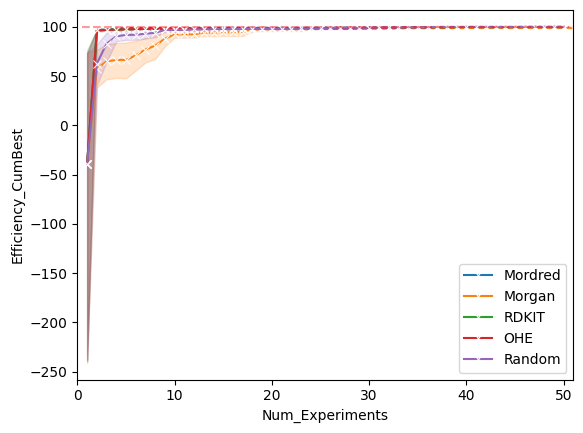

In [40]:
# all experiments
sns.lineplot(
    data=results, x="Num_Experiments", y="Efficiency_CumBest", hue="Scenario", marker="x"
)
plt.plot([0.5, N_DOE_ITERATIONS+0.5], [max_yield, max_yield], "--r", alpha=0.4)
plt.legend(loc="lower right")
import matplotlib.pyplot as plt

plt.xlim(0, N_DOE_ITERATIONS+1)
plt.savefig(f"./img/{exp_dataset_name}_simulation_{N_MC_ITERATIONS}MC_{N_DOE_ITERATIONS}exp_{BATCH_SIZE}batch.png")

In [125]:
results

,Scenario,Random_Seed,Iteration,Num_Experiments,Efficiency_Measurements,Efficiency_IterBest,Efficiency_CumBest
0,Mordred,1337,0,1,[71.38],71.380000,71.380
1,Mordred,1337,1,2,[83.742],83.742000,83.742
2,Mordred,1337,2,3,[67.0],67.000000,83.742
3,Mordred,1337,3,4,[67.04],67.040000,83.742
4,Mordred,1337,4,5,[47.0],47.000000,83.742
...,...,...,...,...,...,...,...
395,Random,1346,5,6,[71.72],71.720000,92.500
396,Random,1346,6,7,[68.00666666666666],68.006667,92.500
397,Random,1346,7,8,[6.08],6.080000,92.500
398,Random,1346,8,9,[90.0],90.000000,92.500


In [ ]:
results.to_excel(f"./results/{exp_dataset_name}_simulation_{N_MC_ITERATIONS}MC_{N_DOE_ITERATIONS}exp_{BATCH_SIZE}batch.xlsx")


# Transfer Learning